# Maximum likelihood retrieval techniques in the presence of Poisson noise

The purpose of this notebook is to play with iterative retrieval algorithms that can be used to extract IFS data, but with the hope that the formalisms that we introduce can be used in other situations as well.

One of the tricky parts is to characterize how much better these algorithms are compared to regular chi-squared extraction/deconvolution methods. One approach is to compare their SNRs. In order to determine the uncertainty (used to compute SNR), we are just going to repeat the flux extraction a large number of times and compute the standard deviation of the estimates.

One other tricky part is to know whether the extraction is biased, and quantify how much. We are going to try to defer this to a later date.

In [1]:
import numpy as np
import glob
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=20)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=20)
plt.rc('image',origin='lower',interpolation='nearest')

import sys
import os

Populating the interactive namespace from numpy and matplotlib


In [3]:
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')

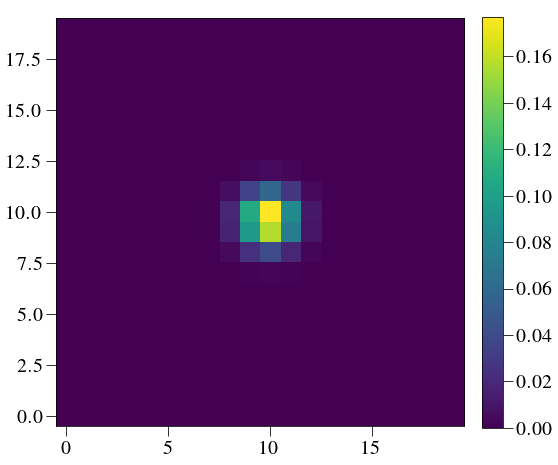

In [13]:
from scipy.special import erf
size = 20
# add some static offset to reflect arbitrary sampling
_x = np.arange(size)-size//2+0.1
_y = np.arange(size)-size//2+0.4
_x, _y = np.meshgrid(_x, _y)
sigma = 2./2.35
psflet = (erf((_x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((_y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_y - 0.5) / (np.sqrt(2) * sigma)))

psflet /= np.sum(psflet)
fsize=8
plt.figure(figsize=(fsize,fsize))
plt.imshow(psflet)
plt.colorbar(fraction=0.046, pad=0.04)


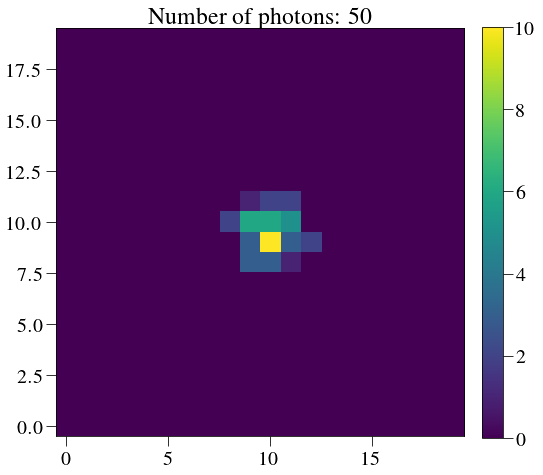

In [94]:
Nphot = 50
img = np.random.poisson(psflet*50)
plt.figure(figsize=(fsize,fsize))
plt.imshow(img)
plt.title('Number of photons: {:}'.format(Nphot))
plt.colorbar(fraction=0.046, pad=0.04)


## Naive matched filter attempt assuming perfect centroid

In [95]:
mf = psflet.copy()
mf /= np.sum(mf**2)

In [96]:
log.info(np.sum(img*mf))

crispy - INFO - 47.6549738183


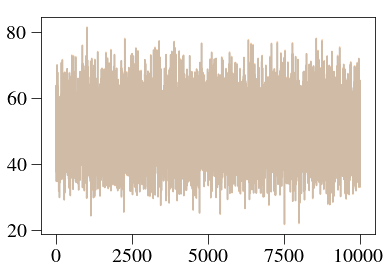

In [117]:
niter = 10000
tsum = np.zeros(niter)
matched_filtered = np.zeros(niter)
linregress = np.zeros(niter)
wls_model = np.zeros(niter)
for i in range(niter):
    img = np.random.poisson(psflet*Nphot)
    matched_filtered[i] = np.sum(img*mf)
    tsum[i] = np.sum(img)
    linregress[i]= scipy.stats.linregress(np.reshape(psflet,-1), np.reshape(img,-1))[0]
    wls_tmp = sm.WLS(np.reshape(img,-1).T, np.reshape(psflet,-1).T, weights=1./np.reshape(psflet+1e-10,-1).T)
    results = wls_tmp.fit()
    wls_model[i]=results.params[0]
    
plt.plot(matched_filtered,alpha=0.3)
plt.plot(linregress,alpha=0.3)

In [118]:
log.info("Sum | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(tsum),np.std(tsum),np.sqrt(np.mean(tsum)),np.mean(tsum)/np.std(tsum)))
log.info("Matched filter | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(matched_filtered),np.std(matched_filtered),np.sqrt(np.mean(matched_filtered)),np.mean(matched_filtered)/np.std(matched_filtered)))
log.info("Linear regression | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(linregress),np.std(linregress),np.sqrt(np.mean(linregress)),np.mean(linregress)/np.std(linregress)))
log.info("Poisson-weighted lstsq | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(wls_model),np.std(wls_model),np.sqrt(np.mean(wls_model)),np.mean(wls_model)/np.std(wls_model)))

crispy - INFO - Sum | Mean: 50.127, Std: 7.18, sqrt(Mean): 7.08, SNR: 6.98
crispy - INFO - Matched filter | Mean: 50.104, Std: 8.24, sqrt(Mean): 7.08, SNR: 6.08
crispy - INFO - Linear regression | Mean: 50.103, Std: 8.29, sqrt(Mean): 7.08, SNR: 6.04
crispy - INFO - Poisson-weighted lstsq | Mean: 50.127, Std: 7.18, sqrt(Mean): 7.08, SNR: 6.98


## Now with two sources

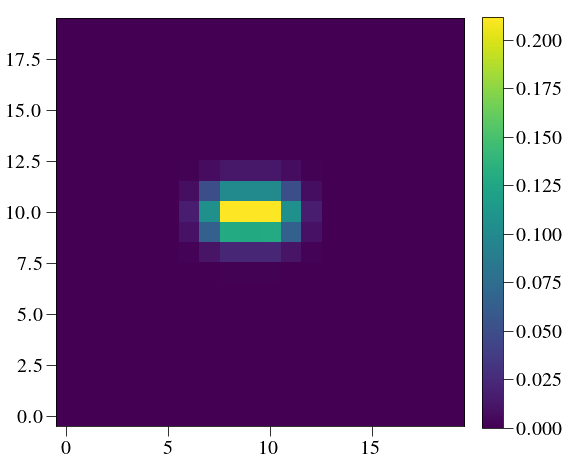

In [225]:
_x = np.arange(size)-size//2+2
_y = np.arange(size)-size//2+0.1
_x, _y = np.meshgrid(_x, _y)
sigma = 2./2.35
psflet1 = (erf((_x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((_y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_y - 0.5) / (np.sqrt(2) * sigma)))

psflet1 /= np.sum(psflet1)

_x = np.arange(size)-size//2
_y = np.arange(size)-size//2+0.1
_x, _y = np.meshgrid(_x, _y)
sigma = 2./2.35
psflet2 = (erf((_x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((_y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_y - 0.5) / (np.sqrt(2) * sigma)))

psflet2 /= np.sum(psflet2)



plt.figure(figsize=(fsize,fsize))
plt.imshow(psflet1+psflet2)
plt.colorbar(fraction=0.046, pad=0.04)


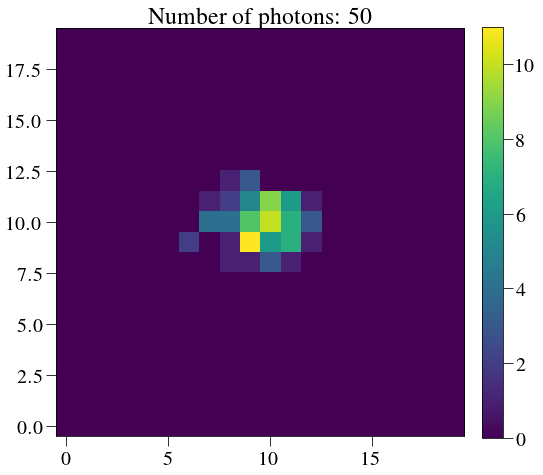

In [323]:
Nphot1 = 20
Nphot2 = 80
img = np.random.poisson(psflet1*Nphot1+psflet2*Nphot2)
plt.figure(figsize=(fsize,fsize))
plt.imshow(img)
plt.title('Number of photons: {:}'.format(Nphot))
plt.colorbar(fraction=0.046, pad=0.04)


In [214]:
psflets = np.zeros((2,psflet1.shape[0],psflet1.shape[1]))
psflets[0] = psflet1.copy()
psflets[1] = psflet2.copy()
psflets_flat = np.reshape(psflets, (psflets.shape[0], -1))

In [324]:
subim_flat = np.reshape(img, -1)
coef = np.linalg.lstsq(psflets_flat.T, subim_flat)[0]

In [325]:
print coef

[ 18.90414523  66.34216507]


## Richardson-Lucy method in the presence of Poisson noise

Method is:
1. Use least squares as first guess
2. Update next guess according to Snyder et al 1993 Eq. 4
3. Stop at some point (e.g. when change from step to step is under a threshold

In [331]:
def RL(img,psflets,eps=1e-10):
    #1.
    psflets_flat = np.reshape(psflets.copy(), (psflets.shape[0], -1))
    img_flat = np.reshape(img, -1)
    # guess has dimensions of psflets.shape[0]
    guess = np.linalg.lstsq(psflets_flat.T, img_flat)[0]
    #guess = [ 1, 1]
    res = []
    res.append(guess)
    loglike = []
    ll = -np.sum(np.dot(guess,psflets_flat)) + np.sum(np.log(np.dot(guess,psflets_flat)+1e-10)*img_flat)
    prevll = -np.inf
    loglike.append(ll)
    val = guess.copy()
    count = 0
    while ll-prevll > eps:
        prev = val.copy()
        prevll = ll.copy()
        ll = -np.sum(np.dot(prev,psflets_flat)) + np.sum(np.log(np.dot(prev,psflets_flat)+1e-10)*img_flat)
        loglike.append(ll)
        #2. update
        val = prev*np.sum(psflets_flat*img_flat/(np.dot(prev,psflets_flat)+1e-10),axis=1)
        res.append(val)
        count += 1
    return val,np.array(res),np.array(loglike),count

/Users/mrizzo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log


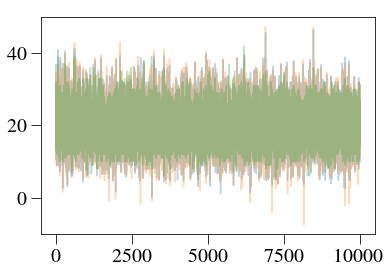

In [357]:
niter = 10000
lstsq = np.zeros((2,niter))
lucy = np.zeros((2,niter))
true = np.zeros((2,niter))
for i in range(niter):
#     min_num_int = max(np.amax(psflet1)*Nphot1/0.1,np.amax(psflet2)*Nphot2/0.1)
#     img1 = np.zeros_like(psflet1)
#     img2 = np.zeros_like(psflet2)
#     for j in range(int(min_num_int)):
#         val = np.random.poisson(psflet1*Nphot1/min_num_int)
#         img1 += val
#         val = np.random.poisson(psflet2*Nphot2/min_num_int)
#         img2 += val
    img1 = np.random.poisson(psflet1*Nphot1)
    img2 = np.random.poisson(psflet2*Nphot2)
    img = img1+img2
    subim_flat = np.reshape(img/(np.sqrt(psflet1+psflet2)+1e-10), -1)
    sumpsflets = np.reshape(psflet1+psflet2,-1)
    lstsq[:,i] = np.linalg.lstsq(psflets_flat.T/(np.sqrt(sumpsflets[:,np.newaxis]+1e-10)), subim_flat)[0]
    lucy[:,i] = RL(img,psflets_flat)[0]
    true[0,i] = np.sum(img1)
    true[1,i] = np.sum(img2)

    
plt.plot(lstsq[0],alpha=0.3)
plt.plot(lucy[0],alpha=0.3)
plt.plot(true[0],alpha=0.3)


In [358]:
log.info("True 1  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(true[0]),np.std(true[0]),np.sqrt(np.mean(true[0])),np.mean(true[0])/np.std(true[0])))
log.info("True 2  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(true[1]),np.std(true[1]),np.sqrt(np.mean(true[1])),np.mean(true[1])/np.std(true[1])))
log.info("Lstsq 1  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(lstsq[0]),np.std(lstsq[0]),np.sqrt(np.mean(lstsq[0])),np.mean(lstsq[0])/np.std(lstsq[0])))
log.info("Lstsq 2  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(lstsq[1]),np.std(lstsq[1]),np.sqrt(np.mean(lstsq[1])),np.mean(lstsq[1])/np.std(lstsq[1])))
log.info("lucy 1  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(lucy[0]),np.std(lucy[0]),np.sqrt(np.mean(lucy[0])),np.mean(lucy[0])/np.std(lucy[0])))
log.info("lucy 2  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(lucy[1]),np.std(lucy[1]),np.sqrt(np.mean(lucy[1])),np.mean(lucy[1])/np.std(lucy[1])))


crispy - INFO - True 1  | Mean: 19.990, Std: 4.47, sqrt(Mean): 4.47, SNR: 4.47
crispy - INFO - True 2  | Mean: 79.949, Std: 8.84, sqrt(Mean): 8.94, SNR: 9.04
crispy - INFO - Lstsq 1  | Mean: 19.992, Std: 5.9, sqrt(Mean): 4.47, SNR: 3.39
crispy - INFO - Lstsq 2  | Mean: 79.947, Std: 9.66, sqrt(Mean): 8.94, SNR: 8.27
crispy - INFO - lucy 1  | Mean: 19.983, Std: 5.95, sqrt(Mean): 4.47, SNR: 3.36
crispy - INFO - lucy 2  | Mean: 79.953, Std: 9.69, sqrt(Mean): 8.94, SNR: 8.25


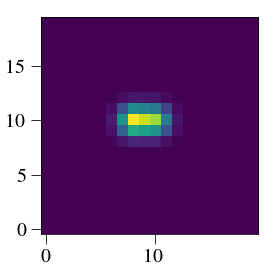

In [224]:
plt.imshow(np.reshape(np.dot(coef.T,psflets_flat),img.shape))

In [222]:
print coef

[ 48.1825016   39.69909826]


[ 48.1825016   39.69909826] [ 56.57013885  42.42986115]
(400,)


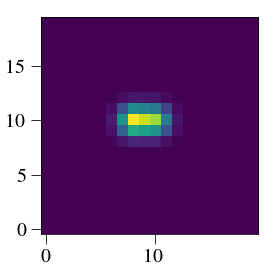

In [223]:
img_flat = np.reshape(img, -1)
new = coef*np.sum(psflets_flat*img_flat/(np.dot(coef,psflets_flat)+1e-10),axis=1)
print coef,new
print np.dot(coef.T,psflets_flat).shape
plt.figure()
plt.imshow(np.reshape(np.dot(coef.T,psflets_flat),img.shape))


In [301]:
val,chain,loglike = RL(img,psflets,nit=12)
print val

[ 58.13090417  40.86909582]


(13, 2)


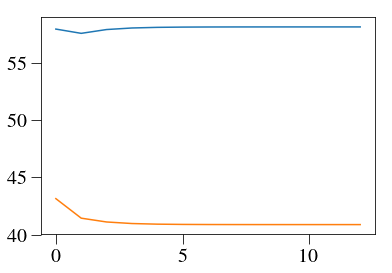

In [302]:
print chain.shape
plt.plot(chain[:,0])
plt.plot(chain[:,1])

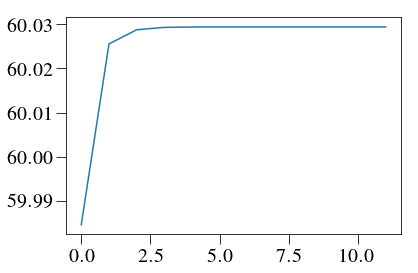

In [303]:
plt.plot(loglike)

In [292]:
print chain

[[ 57.94294441  43.13597979]
 [ 57.56976204  41.43023795]
 [ 57.90232254  41.09767746]
 [ 58.03773666  40.96226333]
 [ 58.09292922  40.90707077]
 [ 58.11543399  40.884566  ]
 [ 58.12461185  40.87538814]
 [ 58.12835501  40.87164498]
 [ 58.12988169  40.8701183 ]
 [ 58.13050437  40.86949562]
 [ 58.13075834  40.86924166]
 [ 58.13086192  40.86913807]
 [ 58.13090417  40.86909582]
 [ 58.1309214   40.86907859]
 [ 58.13092843  40.86907156]
 [ 58.1309313   40.8690687 ]
 [ 58.13093246  40.86906753]
 [ 58.13093294  40.86906705]
 [ 58.13093314  40.86906686]
 [ 58.13093322  40.86906678]
 [ 58.13093325  40.86906674]
 [ 58.13093326  40.86906673]
 [ 58.13093327  40.86906673]
 [ 58.13093327  40.86906672]
 [ 58.13093327  40.86906672]
 [ 58.13093327  40.86906672]
 [ 58.13093327  40.86906672]
 [ 58.13093327  40.86906672]
 [ 58.13093327  40.86906672]
 [ 58.13093327  40.86906672]
 [ 58.13093327  40.86906672]
 [ 58.13093327  40.86906672]
 [ 58.13093327  40.86906672]
 [ 58.13093327  40.86906672]
 [ 58.13093327

(400,)


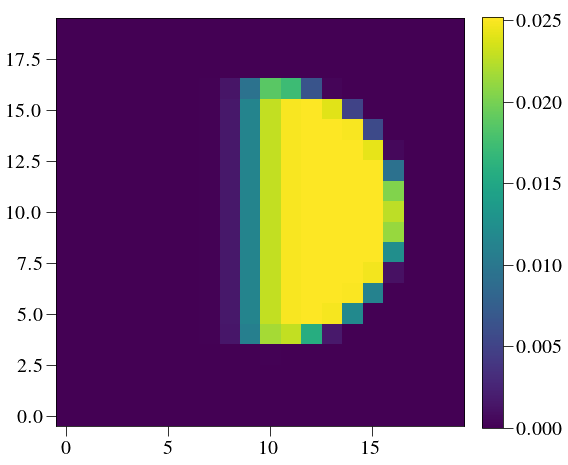

In [251]:
print psflets_flat[0].shape
vals = psflets_flat/(np.dot(coef,psflets_flat)+1e-10)
plt.figure(figsize=(fsize,fsize))
plt.imshow(np.reshape(vals.T[:,1],img.shape))
plt.colorbar(fraction=0.046, pad=0.04)
